# Part 1: Retrieving data

### 1.1: Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt
import numpy as np
import urllib.request
import math
import plotly.graph_objects as go

### 1.2: Download dataset & create dataframe

In [2]:
url = 'https://data.humdata.org/hxlproxy/api/data-preview.csv?url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2Ftime_series_covid19_confirmed_global.csv&filename=time_series_covid19_confirmed_global.csv'
urllib.request.urlretrieve(url, 'corona_confirmed.csv')
dataset = pd.read_csv('corona_confirmed.csv')
# here we rename "Country/Region" column to "Country" to avoid slashes
dataset = dataset.rename(columns={"Country/Region": "Country"})

### 1.3: Helper query for extracting a single country from dataframe
Please note that it doesn't work (yet) with countries with multiple districts reported (such as China or USA)

In [3]:
get_country = lambda x: dataset.query(f'Country == "{x}"').drop(columns=['Province/State', 'Country', 'Lat', 'Long'])

### 1.4: Define a country we want to test and get its infection data

In [4]:
country_name = 'Poland'
country = get_country(country_name)
plot_x = np.arange(len(country.keys().tolist()))
plot_y = country.values.tolist()[0] 

# find the first nonzero value of infected
for idx, elem in enumerate(plot_y):
    if elem !=0:
        break;
begin_day = idx

# cut down the x and y values to exclude 0 infected days
plot_y = plot_y[begin_day:]
plot_x = plot_x[begin_day:]

# Part 2: Approximating the exponential infections' curve

### 2.1: Define an exponential function that we'll be trying to match to infections
amplitude: a small A gives a small amplitude

shape: a small c controls the shape by flattening the "knee" of the curve

position: d sets the y-intercept

orientation: a negative A flips the curve across a horizontal axis; a negative c flips the curve across a vertical axis

In [5]:
def func(x, A, c, d):
    return A*np.exp(c*x) + d

pred_func = func

### 2.2: Survey
To use least squares regression, we must have a initial guess - a very rough estimate of the resulting curve. Here we plot some sample functions of chosen A, c, d and choose the one that is the closest to the sampled points.

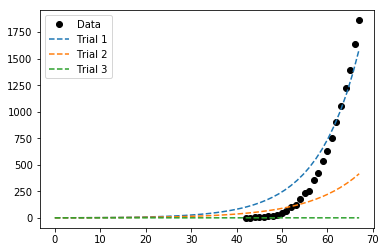

In [6]:
# Plotting sampled data
plt.plot(plot_x, plot_y, "ko", label="Data")
x_lin = np.linspace(0, plot_x.max(), 50)

# Trials
A, c, d = 1, 0.11, 1
y_trial1 = pred_func(x_lin,  A,     c, d)
y_trial2 = pred_func(x_lin, 1, 0.09, 1)
y_trial3 = pred_func(x_lin, 1, -3e-3, 1)

plt.plot(x_lin, y_trial1, "--", label="Trial 1")
plt.plot(x_lin, y_trial2, "--", label="Trial 2")
plt.plot(x_lin, y_trial3, "--", label="Trial 3")
plt.legend()

### 2.3: Regression - use least squares curve fit to estimate the curve parameters

In [7]:
def least_square_curve_fit(func, x, y, p0 = [1, 0.11, 1]):
    w, _ = opt.curve_fit(func, x, y, p0=p0)
    return w

p0 = [A, c, d] # guessed params
w = least_square_curve_fit(pred_func, plot_x, plot_y, p0=p0)     
print("Estimated Parameters", w)  

Estimated Parameters [  0.10039453   0.14773785 -91.36988364]


### 2.4: Plot estimated curve

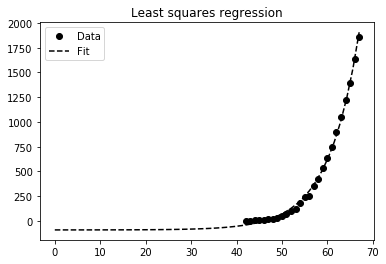

In [8]:
# Model
y_model = pred_func(x_lin, *w)

# PLOT
# Visualize data and fitted curves
plt.plot(plot_x, plot_y, "ko", label="Data")
plt.plot(x_lin, y_model, "k--", label="Fit")
plt.title("Least squares regression")
plt.legend(loc="upper left")

# Part 3: Plotting the graph

### 3.1: Get estimated curve parameters and prepare x axis data for the next `days_forward` days

In [9]:
curve_params = w
plot_x = country.keys().tolist()[begin_day:]
plot_x_old = country.keys().tolist()[begin_day:]

days_forward = 3
dates = pd.date_range(plot_x[-1], periods=days_forward+1, freq='1D')
plot_x = plot_x[:-1]
for date in dates:
    out = date.strftime('X%m/X%d/%Y').replace('X0','X').replace('X','')[:-2]
    plot_x.append(out)

### 3.2: Create a plot.ly figure and add barchart of confirmed cases

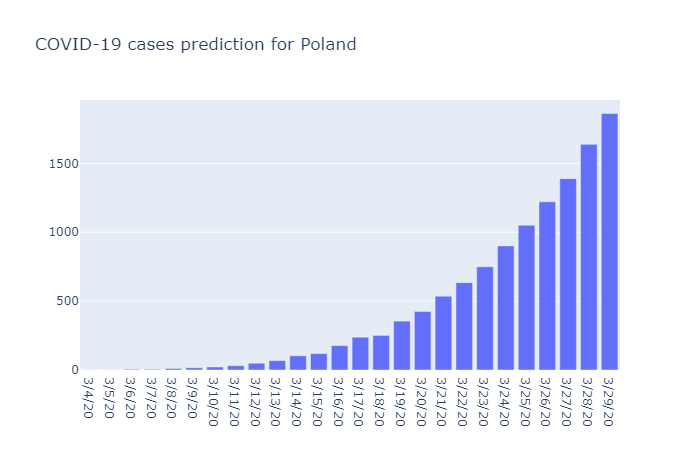

In [10]:
fig = go.Figure()
fig.update_layout(barmode='group', hovermode='x')
fig.update_layout(title = f'COVID-19 cases prediction for {country_name}')
fig.add_trace(go.Bar(y=plot_y, x=plot_x, name='Confirmed cases'))
fig.show(renderer="png")

### 3.3: Plot predictions (estimated curves) for last `number_of_predictions` days

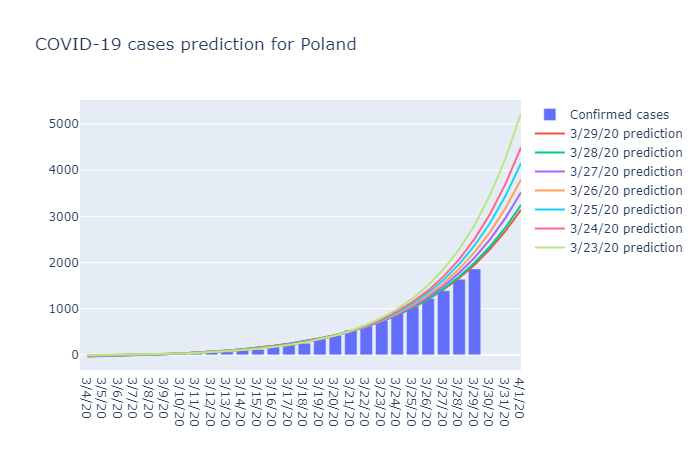

In [11]:
number_of_predictions = 7
for i in range(number_of_predictions):
    curve_params = least_square_curve_fit(func,np.arange(len(plot_x_old[:-i-1])), plot_y[:-i-1])
    func_y = [int(func(x, *curve_params)) for x in np.arange(len(plot_x))]
    fig.add_trace(go.Scatter(y=func_y, x=plot_x, name=f'{plot_x_old[-i-1]} prediction'))
fig.show(renderer="png")

### 3.3.1: (Optional) Add vertical line and prediction on 3/13/20 (beginning of countermeasures)

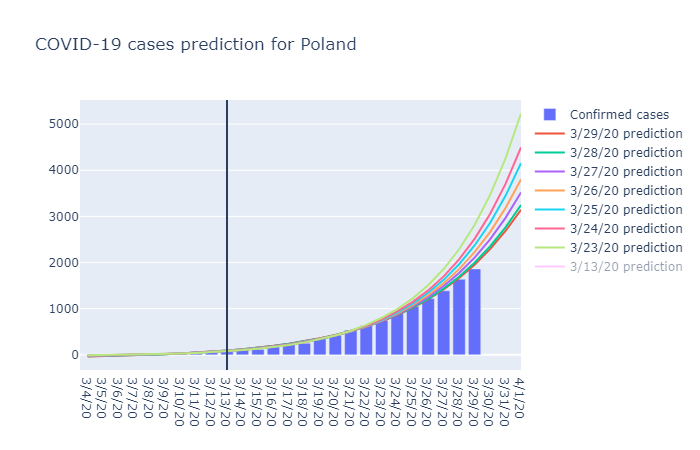

In [12]:
curve_params = least_square_curve_fit(func,np.arange(len(plot_x_old[:9])), plot_y[:9])
func_y = [int(func(x, *curve_params)) for x in np.arange(len(plot_x))]
fig.add_trace(go.Scatter(y=func_y, x=plot_x, name=f'{plot_x_old[9]} prediction', visible='legendonly'))

fig.update_layout(shapes=[
    dict(
      type= 'line',
      yref= 'paper', y0= 0, y1= 1,
      xref= 'x', x0= plot_x_old[9], x1= plot_x_old[9]
    )
])
fig.show(renderer="png")

### 3.4: Save graph to HTML file

In [13]:
fig.write_html("index.html")

# Part 4: See the interactive plot on https://kzawora.github.io